In [9]:
import os
import sys

# Append parent directory to Python path
relative_path = '..'
parent_directory = os.path.abspath(os.path.join(os.getcwd(), relative_path))
sys.path.append(parent_directory)

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
#import stuff from library
from functions.fno_wrapper import FNO1dWrapper as FNO1d
from neuralop import Trainer
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

In [ ]:
from functions.functions import *
from functions.functions_time_model import *
from functions.function_pauli_strings_new_inputs import *
from functions.seed_utilis import *
# from torch.utils.tensorboard import SummaryWriter

In [12]:


seed=1
set_seed(seed) 

In [13]:
current_path = os.getcwd()
print(f"Current working directory: {current_path}")


Current working directory: /home/ec2-user/FNO-for-quantum/12_particles


In [14]:
import pickle
model = pickle.load(
    #open('./checkpoints/FNO_20_25000_obs_120_0.2_0.9/20_22500_lr0.0001_wd0.001_epochs2500_gamma0.99_bs32_hid2048_lift4096_modes8_rank0.5_ReduceLR/model_0.0001_0.99_2500.pkl', 'rb')
#)
    open('./checkpoints/FNO_20_25000_obs_120_0.2_0.9/20_22500_lr0.0001_wd0.001_epochs1700_gamma0.99_bs32_hid2048_lift4096_modes8_rank0.5_ReduceLR/model_0.0001_0.99_1700.pkl', 'rb')
)
    #open('./checkpoints/FNO_20_39743_obs_120_0.2_0.9/20_35768_lr0.0001_wd0.001_epochs2000_gamma0.99_bs32_hid2048_lift4096_modes8_rank0.5_ReduceLR/model_0.0001_0.99_2000.pkl', 'rb')
#)
    #open('./checkpoints/FNO_20_35000_obs_120_0.2_0.9/20_31500_lr0.0002_wd0.001_epochs1700_gamma0.99_bs32_hid1024_lift2048_modes8_rank0.8_ReduceLR/model_0.0002_0.99_1700.pkl', 'rb')
#)
   

model.eval()


FNO1d(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexTuckerTensor(shape=(2048, 2048, 5), rank=(1288, 1288, 3))
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Conv1d(2048, 2048, kernel_size=(1,), stride=(1,), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv1d(122, 4096, kernel_size=(1,), stride=(1,))
      (1): Conv1d(4096, 2048, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv1d(2048, 4096, kernel_size=(1,), stride=(1,))
      (1): Conv1d(4096, 120, kernel_size=(1,), stride=(1,))
    )
  )
)

[Dataset] x_train: 3000, x_test: 0


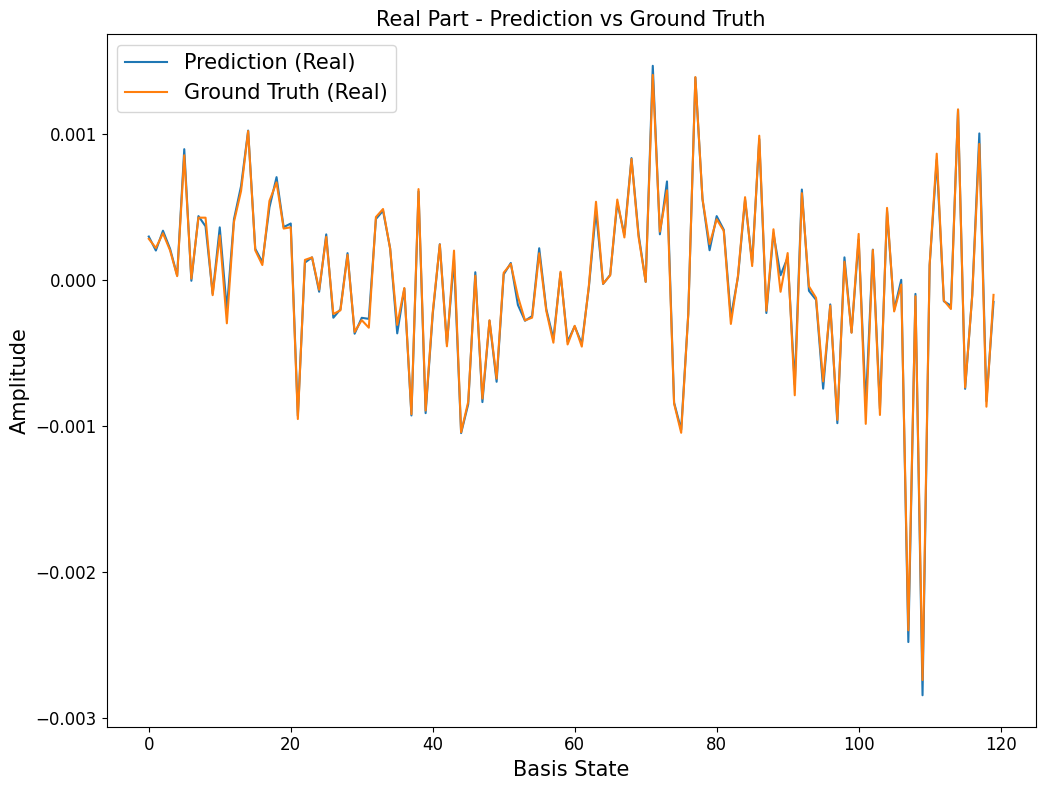

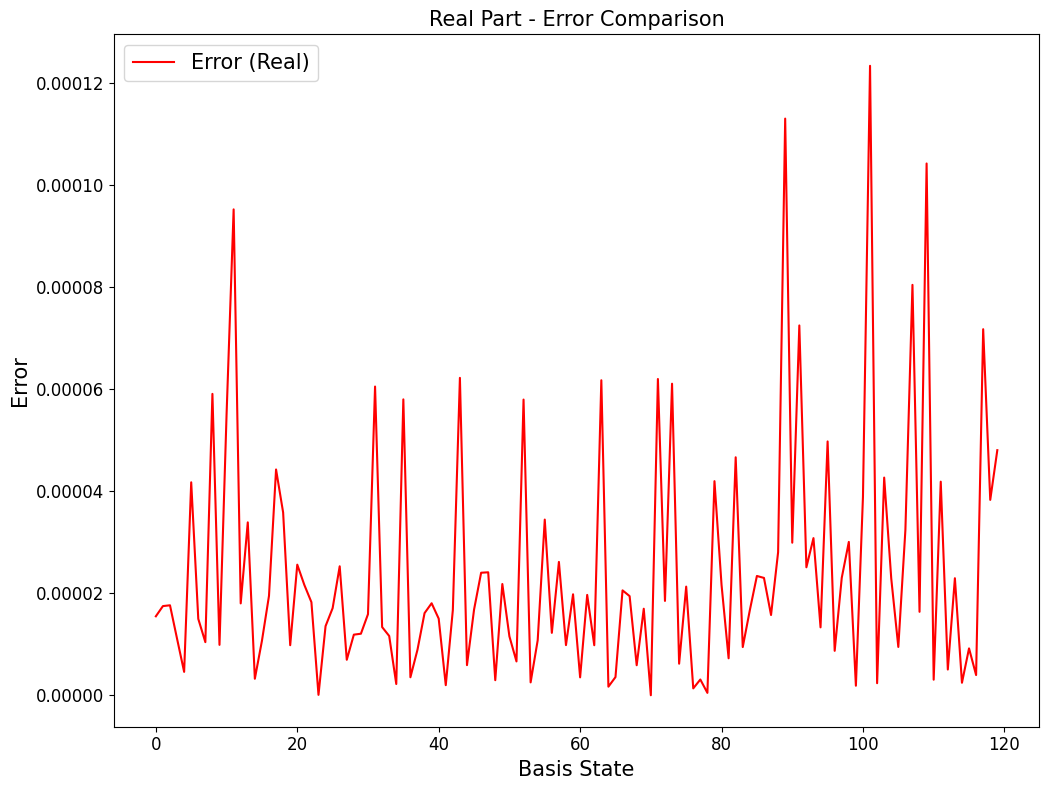

In [15]:

num_states = 3000 # Number of input states
train_ratio = 1  # Ratio of training to testing data
batch_size = 5
input_T=15
output_T=10
data_path='./evaluation_dataset/'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
test_loader, _ = data_preprocess2(data_path, input_T, output_T, num_states, train_ratio, batch_size, device)

# Assuming `test_loader` is already defined
# Iterate through the test dataset and perform inference
predictions_list = []
ground_truth_list = []
for batch in test_loader:
    x, y = batch['x'].cuda(), batch['y'].cuda()  # Move data to GPU if available
    with torch.no_grad(): # add transform/inverse transform or use wrapped model 
        predictions = model(x)  # Perform inference without gradient computation
    predictions_list.append(predictions.cpu())
    ground_truth_list.append(y.cpu())

# Concatenate predictions and ground truth across batches
predictions = torch.cat(predictions_list,dim=0)
ground_truth = torch.cat(ground_truth_list,dim=0)

predictions=predictions[:,:,input_T-output_T:input_T]
ground_truth=ground_truth[:,:,input_T-output_T:input_T]

# Plot the comparison with error
plot_comparison_with_error_pauli_strings(predictions[10,:,5], ground_truth[10,:,5])  # Plot for the first sample in the dataset

In [16]:
class MyDataset_rollout(Dataset):
    def __init__(self, data_path, input_T, output_T, num_states, device, train=True, rollout_steps=2, train_ratio=0.8):
        self.data_path = data_path
        self.files = sorted(os.listdir(data_path))[:num_states]
        self.input_T = input_T
        self.output_T = output_T
        self.train_ratio = train_ratio
        self.rollout_steps = rollout_steps
        self.train = train
        self.device = device

        self.train_size = int(train_ratio * len(self.files))
        self.file_subset = self.files[:self.train_size] if train else self.files[self.train_size:]

    def __len__(self):
        return len(self.file_subset)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_path, self.file_subset[idx])
        data = torch.load(file_path, map_location=self.device)

        input_data = data[:, :, 0:self.input_T].to(self.device)
        output_data = data[:, :, self.output_T:(self.input_T + self.output_T)*self.rollout_steps].to(self.device)

        pos_embedding = PositionalEmbedding(2).to(self.device)
        timesteps = torch.linspace(0, self.input_T - 1, self.input_T, device=self.device)
        positional_embeddings = pos_embedding(timesteps)
        pos = positional_embeddings.T.unsqueeze(0).repeat(1, 1, 1)

        input_data = torch.cat([input_data, pos], dim=1)

        return {'x': input_data.squeeze(0), 'y': output_data.squeeze(0)}

def data_preprocess2_rollout(data_path, input_T, output_T, num_states, train_ratio, batch_size, device, rollout_steps):
    train_dataset = MyDataset_rollout(data_path, input_T, output_T, num_states, device=device, train=True, train_ratio=train_ratio, rollout_steps=rollout_steps)
    test_dataset = MyDataset_rollout(data_path, input_T, output_T, num_states, device=device, train=False, train_ratio=train_ratio, rollout_steps=rollout_steps)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    print(f'[Dataset] x_train: {len(train_dataset)}, x_test: {len(test_dataset)}')
    return train_loader, test_loader


In [17]:
import torch
# -----------------------------
# Predictions (autoregressive rollout)
# -----------------------------

def get_predictions_filewise(model, test_loader, rollout_steps, spatial_grid, output_t, input_t, device='cuda'):
    all_predictions = []
    diff = input_t - output_t
    #all_ground_truths = []
    
    with torch.no_grad():
        for batch in test_loader:
            x = batch['x'].to(device)
            #y = batch['y'].to(device)
            batch_predictions = []

            # initial prediction
            pred = model(x)
            batch_predictions.append(pred[:, :, diff:])  # slice according to diff

            # autoregressive rollout
            for _ in range(rollout_steps - 1):
                pred = torch.cat([pred, spatial_grid], dim=1)
                pred = model(pred)
                batch_predictions.append(pred[:, :, diff:])

            batch_pred_tensor = torch.cat(batch_predictions, dim=-1)
            all_predictions.append(batch_pred_tensor)

    all_predictions = torch.cat(all_predictions, dim=0)
    print(f"[Predictions] shape: {all_predictions.shape}")
    return all_predictions


def get_all_predictions_filewise(model, test_loader, rollout_steps, spatial_grid, output_t, input_t, device='cuda'):
    all_predictions = []
    diff = input_t - output_t
    all_ground_truths = []
    all_predictions_gt = []
    
    with torch.no_grad():
        for batch in test_loader:
            x = batch['x'].to(device)
            y = batch['y'].to(device)
            batch_predictions = []

            # initial prediction
            pred = model(x)
            batch_predictions.append(pred[:, :, diff:])  # slice according to diff
            
            #ground truth for initial prediction
            batch_gt_list = []
            cur_out_t = 0
            ground_truth_val = y[:, :, cur_out_t : cur_out_t + input_t]
            batch_gt_list.append(y[:, :, cur_out_t + diff: cur_out_t + input_t])

            batch_predictions_gt = []

            # autoregressive rollout
            for _ in range(rollout_steps - 1):
                #rollouts on predictions
                pred = torch.cat([pred, spatial_grid], dim=1)
                pred = model(pred)
                batch_predictions.append(pred[:, :, diff:])
                
                #rollouts on ground truths
                pred_on_gt = torch.cat([ground_truth_val, spatial_grid], dim=1)
                pred_on_gt = model(pred_on_gt)
                batch_predictions_gt.append(pred_on_gt[:, :, diff:])

                #ground truths for rollouts
                cur_out_t = cur_out_t + input_t - diff
                ground_truth_val = y[:, :, cur_out_t : cur_out_t + input_t]
                batch_gt_list.append(y[:, :, cur_out_t + diff: cur_out_t + input_t])
                

            batch_pred_tensor = torch.cat(batch_predictions, dim=-1)
            all_predictions.append(batch_pred_tensor)

            batch_gt_pred_tensor = torch.cat(batch_predictions_gt, dim=-1)
            all_predictions_gt.append(batch_gt_pred_tensor)

            batch_gt_tensor = torch.cat(batch_gt_list, dim=-1)
            all_ground_truths.append(batch_gt_tensor)

    all_predictions = torch.cat(all_predictions, dim=0)
    all_predictions_gt = torch.cat(all_predictions_gt, dim=0)
    all_ground_truths = torch.cat(all_ground_truths, dim=0)
    print(f"[Predictions] shape: {all_predictions.shape}")
    print(f"[Predictions GT] shape: {all_predictions_gt.shape}")
    print(f"[Ground Truth] shape: {all_ground_truths.shape}")
    return all_predictions, all_predictions_gt, all_ground_truths

# -----------------------------
# Ground truth (file-wise)
# -----------------------------
def get_ground_truth_filewise(test_loader, rollout_steps, output_t, input_t, overlap=True, device='cuda'):
    all_ground_truths = []

    for batch in test_loader:
        y = batch['y'].to(device)  # batch_size x channels x T

        if overlap:
            diff = input_t - output_t
            batch_gt_list = []
            cur_out_t = 0
            for _ in range(rollout_steps):
                batch_gt_list.append(y[:, :, cur_out_t + diff: cur_out_t + input_t])
                cur_out_t = cur_out_t + input_t - diff
            batch_gt_tensor = torch.cat(batch_gt_list, dim=-1)
        else:
            batch_gt_tensor = y[:, :, output_t * 2: output_t * 2 + input_t * rollout_steps]

        all_ground_truths.append(batch_gt_tensor)

    all_ground_truths = torch.cat(all_ground_truths, dim=0)
    print(f"[Ground Truth] shape: {all_ground_truths.shape}")
    return all_ground_truths

# -----------------------------
# Autoregressive rollout
# -----------------------------
def autoregressive_rollout_filewise(model, test_loader, rollout_steps, spatial_grid, output_t, input_t, overlap=True, device='cuda'):
    #all_predictions = get_predictions_filewise(model, test_loader, rollout_steps, spatial_grid, output_t, input_t, device)
    #all_ground_truths = get_ground_truth_filewise(test_loader, rollout_steps, output_t, input_t, overlap=overlap, device=device)
    all_predictions, all_predictions_gt, all_ground_truths = get_all_predictions_filewise(model, test_loader, rollout_steps, spatial_grid, output_t, input_t, device)
    return all_predictions, all_ground_truths, all_predictions_gt

In [18]:


num_states2 = 30000 # Number of input states
train_ratio = 0.95  # Ratio of training to testing data
batch_size = 5

rollout_steps = 2 # Number of autoregressive rollout steps

start_index=0
timesteps = torch.linspace(start_index, start_index+input_T,input_T)
pos_embedding = PositionalEmbedding(2)
positional_embeddings = pos_embedding(timesteps)
pos=positional_embeddings.T.repeat(batch_size, 1, 1)

rollout_steps = 3
rollout_steps2 = 2
data_path = './dataset_from_checkpoints/'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
_, test_loader = data_preprocess2_rollout(data_path, input_T, output_T, num_states2, device=device, train_ratio=train_ratio,batch_size=batch_size, rollout_steps=rollout_steps)

predictions, ground_truth, predictions_gt = autoregressive_rollout_filewise(
    model, test_loader, rollout_steps2, pos.cuda(), output_T, input_T, overlap=True, device=device)

[Dataset] x_train: 28500, x_test: 1500


[Predictions] shape: torch.Size([1500, 120, 20])
[Predictions GT] shape: torch.Size([1500, 120, 10])
[Ground Truth] shape: torch.Size([1500, 120, 20])


torch.Size([1500, 120, 20])
torch.Size([1500, 120, 20])


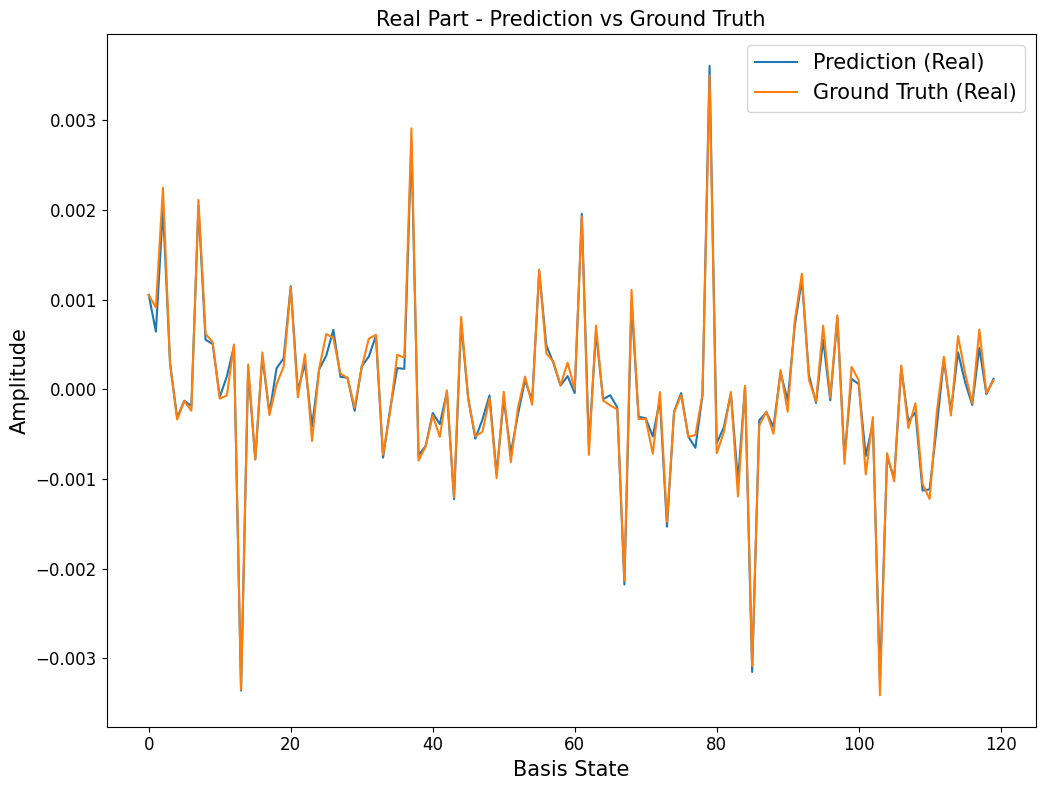

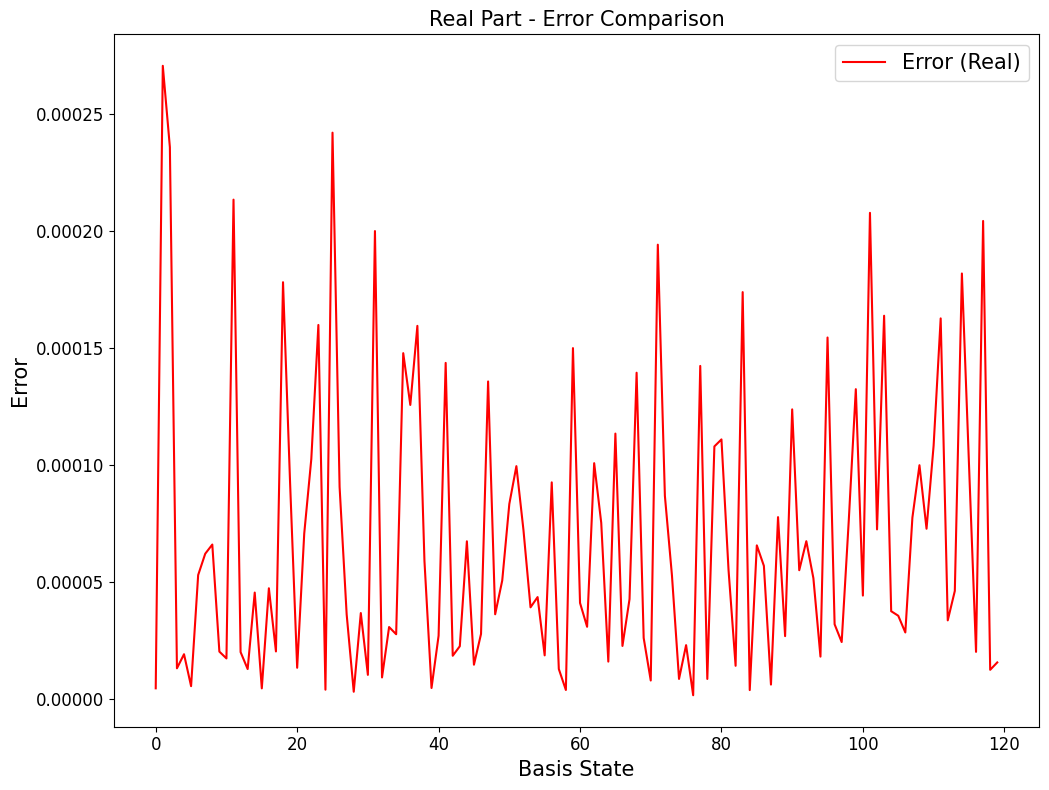

In [19]:
predictions = predictions.cpu()
ground_truth=ground_truth.cpu()
predictions_gt=predictions_gt.cpu()
print(predictions.shape)
print(ground_truth.shape)
plot_comparison_with_error_pauli_strings(predictions_gt[10,:,8], ground_truth[10,:,18]) 

Plotting error metrics...


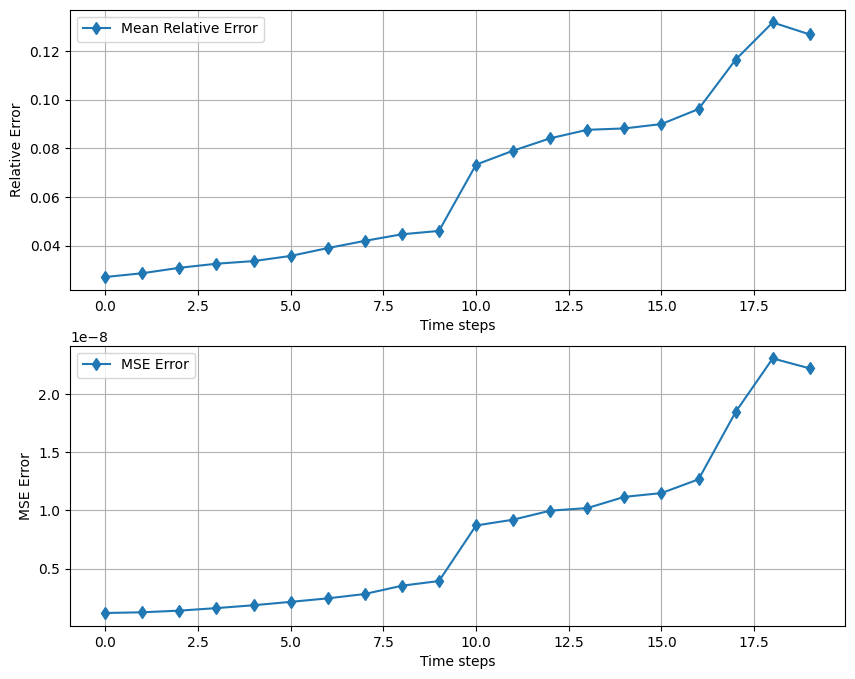

In [20]:
threshold=0.0007
gt_val2, pred_val2, rel_error2, mse_error2 = filter_by_thresh_2(ground_truth, predictions, threshold)

rel_error_mean2 = [np.nanmean(rel) for rel in rel_error2]
mse_error_mean2 = [np.nanmean(mse) for mse in mse_error2]

# Plot error metrics
print("Plotting error metrics...")
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(rel_error_mean2, label='Mean Relative Error', marker='d')
axs[0].set_xlabel('Time steps')
axs[0].set_ylabel('Relative Error')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(mse_error_mean2, label='MSE Error', marker='d')
axs[1].set_xlabel('Time steps')
axs[1].set_ylabel('MSE Error')
axs[1].grid(True)
axs[1].legend()

plt.show()



In [21]:

# Save summary text
mean_rel_error_val2 = np.nanmean(rel_error_mean2)
mean_mse_error_val2 = np.nanmean(mse_error_mean2)
print(f"Mean Relative Error (averaged over time): {mean_rel_error_val2:.6e}\n"
      f"Mean MSE Error (averaged over time): {mean_mse_error_val2:.6e}\n"
      f"Threshold: {threshold}\n")


Mean Relative Error (averaged over time): 6.666064e-02
Mean MSE Error (averaged over time): 7.953593e-09
Threshold: 0.0007



Plotting error metrics...


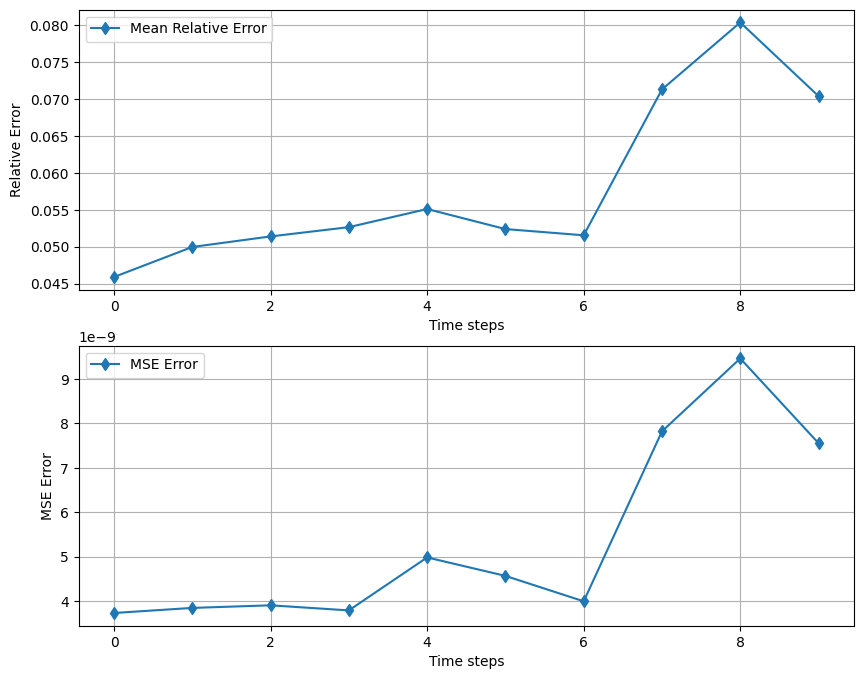

In [22]:
threshold=0.0007
gt_val, pred_val, rel_error, mse_error = filter_by_thresh_2(ground_truth[:,:,10:], predictions_gt, threshold)

rel_error_mean = [np.nanmean(rel) for rel in rel_error]
mse_error_mean = [np.nanmean(mse) for mse in mse_error]

# Plot error metrics
print("Plotting error metrics...")
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(rel_error_mean, label='Mean Relative Error', marker='d')
axs[0].set_xlabel('Time steps')
axs[0].set_ylabel('Relative Error')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(mse_error_mean, label='MSE Error', marker='d')
axs[1].set_xlabel('Time steps')
axs[1].set_ylabel('MSE Error')
axs[1].grid(True)
axs[1].legend()

plt.show()



In [23]:
# Save summary text
mean_rel_error_val = np.nanmean(rel_error_mean)
mean_mse_error_val = np.nanmean(mse_error_mean)
print(f"Mean Relative Error (averaged over time): {mean_rel_error_val:.6e}\n"
      f"Mean MSE Error (averaged over time): {mean_mse_error_val:.6e}\n"
      f"Threshold: {threshold}\n")

Mean Relative Error (averaged over time): 5.810220e-02
Mean MSE Error (averaged over time): 5.363994e-09
Threshold: 0.0007



Mean relative error (rollout): 0.0581022
Standard deviation relative error (rollout): 0.010944018


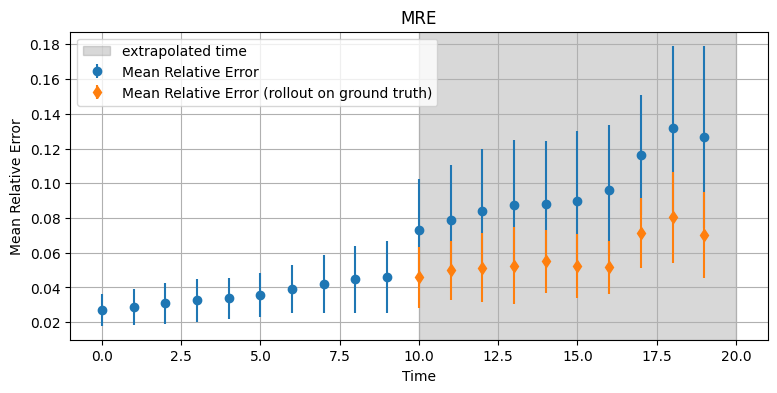

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Assuming rel_error, mse_error, rel_error2, mse_error2 are already defined
# Calculate mean and std for both sets
rel_error_mean = [np.mean(rel) for rel in rel_error]
rel_error_std = [np.std(rel) for rel in rel_error]

rel_error_mean2 = [np.mean(rel) for rel in rel_error2]
rel_error_std2 = [np.std(rel) for rel in rel_error2]

# Create a figure with two subplots for concatenated plots
fig, axs = plt.subplots(figsize=(9, 4))

len1 = len(rel_error_mean2)  # train time
len2 = len(rel_error_mean)   # rollout

# The rollout should overlap with the tail of the train time
# So it starts from len1 - len2 and ends at len1
x_train = range(len1)
x_rollout = range(len1 - len2, len1)

# Plot Relative Error: Train time and rollout with overlap
axs.errorbar(x_train, rel_error_mean2, yerr=rel_error_std2, fmt='o', label='Mean Relative Error')
axs.errorbar(x_rollout, rel_error_mean, yerr=rel_error_std, fmt='d', label='Mean Relative Error (rollout on ground truth)')

# Add grey background only for the overlapping region
axs.axvspan(len1 - len2, len1, color='grey', alpha=0.3, label='extrapolated time')
# Labels, title, legend, and grid (unchanged)
axs.set_xlabel('Time')
axs.set_ylabel('Mean Relative Error')
axs.set_title('MRE')
axs.legend(loc='upper left')
axs.grid(True)

# Print the mean values
print("Mean relative error (rollout):", np.mean(rel_error_mean))
print("Standard deviation relative error (rollout):", np.std(rel_error_mean))

